In [118]:
%load_ext autoreload
%autoreload 2

# Use JH default kernel 
# pip install pyelastix
# pip install opencv-python

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [119]:
from elastix_registration import ElastixRegistration
import matplotlib.pyplot as plt
import os
import numpy as np
from skimage.io import imread, imsave
from skimage.transform import rescale, resize, warp
import cv2

In [120]:
DPI = 300

def plot_overlay(fixed_image, moving_image):
    plt.close("all")
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(fixed_image, cmap="gray")
    ax[0].set_title("Fixed image")
    ax[1].imshow(moving_image, cmap="gray")
    ax[1].set_title("Moving image")
    rgb = np.dstack([fixed_image, moving_image, np.zeros_like(fixed_image)])
    # scale to 0-255
    rgb = (rgb - rgb.min()) / (rgb.max() - rgb.min()) * 255
    rgb = rgb.astype(np.uint8)
    ax[2].imshow(rgb)
    ax[2].set_title("Overlay")
    for a in ax:
        a.axis("off")
    plt.tight_layout()


def warp_via_vectorfield(img, field):
    nr, nc = img.shape
    row_coords, col_coords = np.meshgrid(np.arange(nr), np.arange(nc), indexing='ij')
    u, v = field
    warped = warp(img, np.array([row_coords + v, col_coords + u]), order=1, mode="constant", cval=0, preserve_range=True).astype(np.uint8)
    return warped


def resize_func(image1, image2):
    # image 2 is resized to the size of image 1
    height1, width1 = image1.shape[:2]
    height2, width2 = image2.shape[:2]
    if height1 != height2 or width1 != width2:
        image2_resized = cv2.resize(image2, (width1, height1), interpolation=cv2.INTER_AREA)
        return image1, image2_resized
    return image1, image2

In [121]:
# he_dir = "/projectbig/jupyternotebook/xenium_cgn/robin_xenium_cgn_from_epyc/seperate_samples/registered_he/sift_0/cropped/rotated/"
# dapi_dir = "/projectbig/jupyternotebook/xenium_cgn/robin_xenium_cgn_from_epyc/seperate_samples/imgs_LEVEL1_new/"
# save_dir = "/projectbig/jupyternotebook/xenium_cgn/registered_HE_LEVEL1/"

he_dir = "data_level_1/he_croped/"
dapi_dir = "data_level_1/dapi/"
save_dir = "data_level_1/he_registered/"

sample = 'X9'
he_image = he_dir + sample + '.tif'
dapi_image = dapi_dir + sample + '.tiff'

# dapi_image = "/projectbig/jupyternotebook/xenium_cgn/robin_xenium_cgn_from_epyc/seperate_samples/imgs1/slide1_X1_Cntrl_0.tiff"

In [122]:
fixed_image_original = imread(dapi_image)
# fixed_image = rescale(fixed_image, 1, preserve_range=True)
# rescale to 0-255
# fixed_image = (fixed_image - fixed_image.min()) / (fixed_image.max() - fixed_image.min()) * 255
# fixed_image = fixed_image.astype(np.uint8)
fixed_image_original.shape  

(7272, 2928, 3)

In [123]:
moving_image_original = imread(he_image)
# moving_image = rescale(moving_image, 1, preserve_range=True)
# rescale to 0-255
# moving_image = (moving_image - moving_image.min()) / (moving_image.max() - moving_image.min()) * 255
# moving_image = moving_image.astype(np.uint8)
moving_image_original.shape

(26388, 8436, 3)

In [124]:
# Resize H&E to DAPI
fixed_image_original, moving_image_original = resize_func(fixed_image_original, moving_image_original)

In [125]:
fixed_image_original.shape, moving_image_original.shape

((7272, 2928, 3), (7272, 2928, 3))

In [126]:
# Convert images to grayscale
## Image 1 is RGB and needs to be converted into grayscale
moving_image = cv2.cvtColor(moving_image_original, cv2.COLOR_BGR2GRAY)

## Image 2 is already a grayscale image, but then we need to normalize it
try:
    fixed_image = cv2.cvtColor(fixed_image_original, cv2.COLOR_BGR2GRAY)
except:
    gray2 = cv2.normalize(image2, None, 0, 255, cv2.NORM_MINMAX)
    gray2 = gray2.astype(np.uint8)

## Equalize histograms
# fixed_image = cv2.equalizeHist(fixed_image)
# moving_image = cv2.equalizeHist(moving_image)

In [127]:
fixed_image.shape, moving_image.shape

((7272, 2928), (7272, 2928))

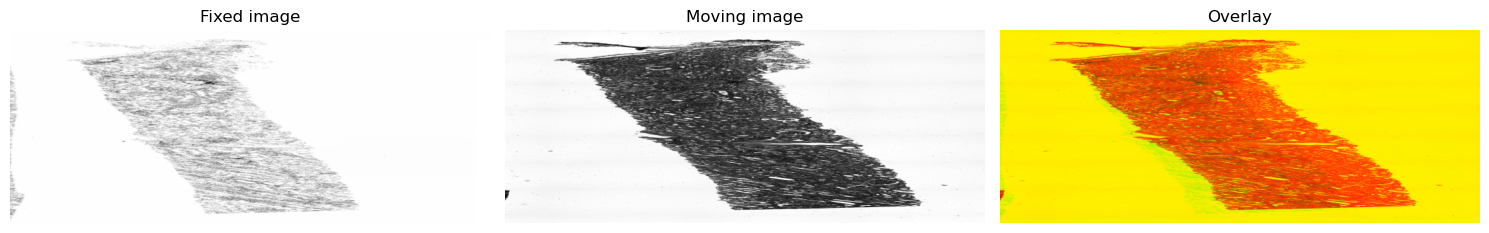

In [128]:
# plot_overlay(fixed_image[:,:], warped[:,:])

height1, width1 = fixed_image.shape
height2, width2 = moving_image.shape

plot_overlay(
    cv2.resize(fixed_image, (int(height1/10), int(width1/10)), interpolation=cv2.INTER_AREA),
    cv2.resize(moving_image, (int(height2/10), int(width2/10)), interpolation=cv2.INTER_AREA),
)

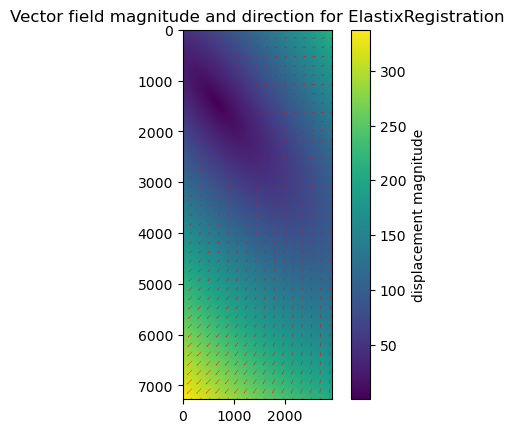

In [129]:
STEP1_CONF =  {
    "max_num_it": 500,
    "nr_res": 40, # 20
    "metric": "AdvancedNormalizedCorrelation",
    "nr_histogram_bins": 128,   #128
    "nr_spatial_samples": 2048 * 10,
    "transform": "AffineTransform",
    "bspline_grid_spacing": 100,
}

elastix = ElastixRegistration(STEP1_CONF)
_, field1 = elastix.register_images(fixed_image, moving_image, plot_vectorfield=True, return_vectorfield=True)
warped = warp_via_vectorfield(moving_image, field1)

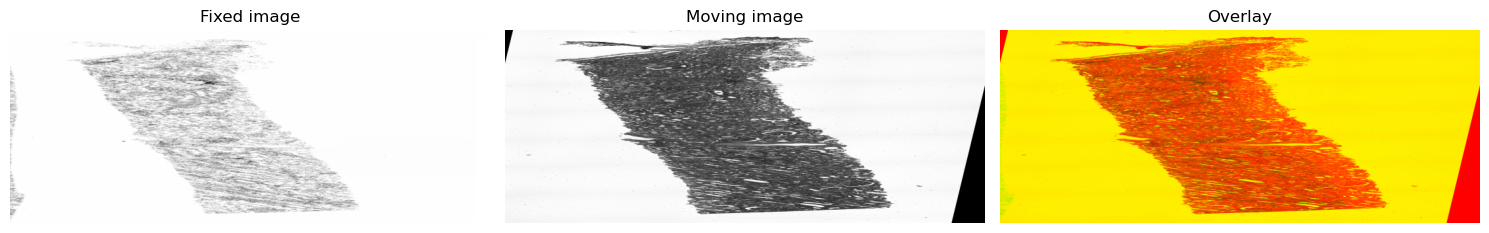

In [130]:
# plot_overlay(fixed_image[:,:], warped[:,:])

height1, width1 = fixed_image.shape
height2, width2 = warped.shape

plot_overlay(
    cv2.resize(fixed_image, (int(height1/10), int(width1/10)), interpolation=cv2.INTER_AREA),
    cv2.resize(warped, (int(height2/10), int(width2/10)), interpolation=cv2.INTER_AREA),
)

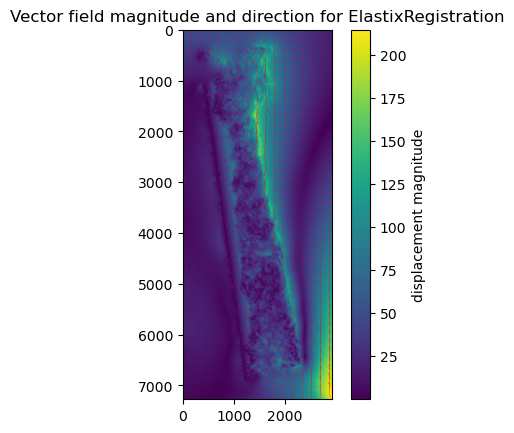

In [131]:
STEP2_CONF =  {
    "max_num_it": 1000,
    "nr_res": 100,
    "metric": "AdvancedNormalizedCorrelation",
    "nr_histogram_bins": 128 * 1,
    "nr_spatial_samples": 2048 * 10,
    "bspline_grid_spacing": 20,
    "transform": "BSplineTransform",
    }

# STEP2_CONF =  {
#     "max_num_it": 500,
#     "nr_res": 40, # 20
#     "metric": "AdvancedNormalizedCorrelation",
#     "nr_histogram_bins": 128,   #128
#     "nr_spatial_samples": 2048 * 10,
#     "transform": "AffineTransform",
#     "bspline_grid_spacing": 100,
# }

elastix = ElastixRegistration(STEP2_CONF)
_, field2 = elastix.register_images(fixed_image, warped, plot_vectorfield=True, return_vectorfield=True)
warped = warp_via_vectorfield(warped, field2)

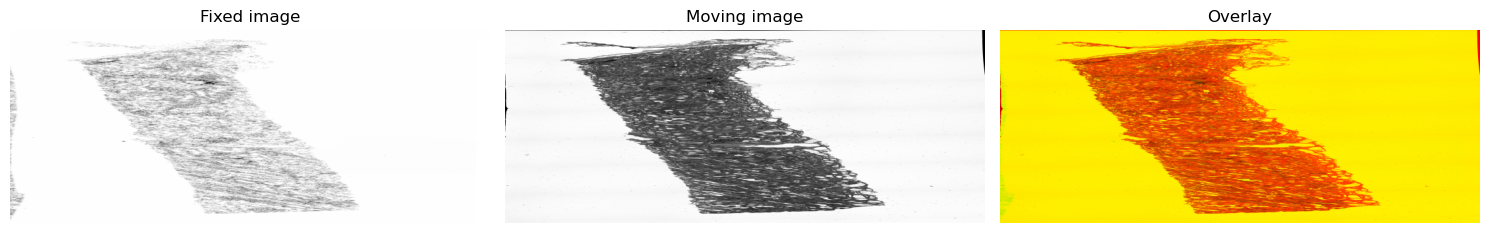

In [132]:
# plot_overlay(fixed_image, warped)

height1, width1 = fixed_image.shape
height2, width2 = warped.shape

plot_overlay(
    cv2.resize(fixed_image, (int(height1/10), int(width1/10)), interpolation=cv2.INTER_AREA),
    cv2.resize(warped, (int(height2/10), int(width2/10)), interpolation=cv2.INTER_AREA),
)

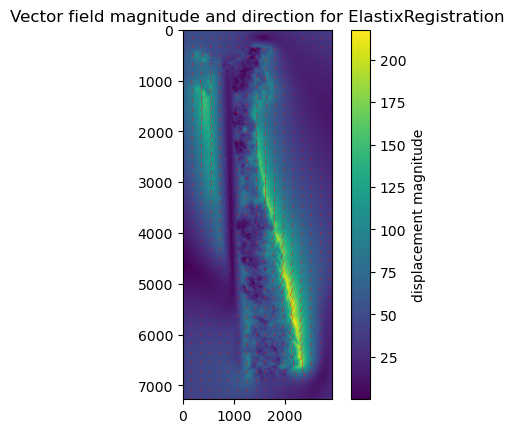

In [114]:
STEP3_CONF =  {
    "max_num_it": 1000,
    "nr_res": 100,
    "metric": "AdvancedNormalizedCorrelation",
    "nr_histogram_bins": 128 * 1,
    "nr_spatial_samples": 2048 * 10,
    "bspline_grid_spacing": 20,
    "transform": "BSplineTransform",
    }

elastix = ElastixRegistration(STEP3_CONF)
_, field3 = elastix.register_images(fixed_image, warped, plot_vectorfield=True, return_vectorfield=True)
warped = warp_via_vectorfield(warped, field3)

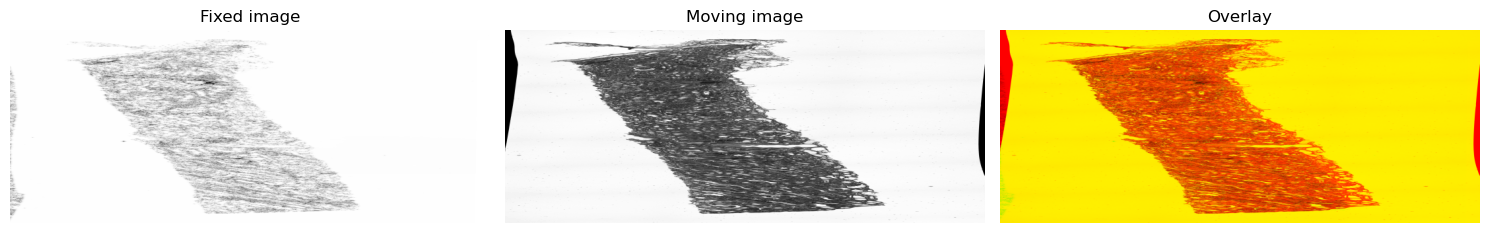

In [115]:
# plot_overlay(fixed_image, warped)

height1, width1 = fixed_image.shape
height2, width2 = warped.shape

plot_overlay(
    cv2.resize(fixed_image, (int(height1/10), int(width1/10)), interpolation=cv2.INTER_AREA),
    cv2.resize(warped, (int(height2/10), int(width2/10)), interpolation=cv2.INTER_AREA),
)

In [133]:
reg = np.zeros_like(moving_image_original)

for i in range(3):  # Loop over the RGB channels
    channel = moving_image_original[:,:,i]
    warped_channel_1 = warp_via_vectorfield(channel, field1)
    warped_channel_2 = warp_via_vectorfield(warped_channel_1, field2)
    warped_channel_3 = warp_via_vectorfield(warped_channel_2, field3)
    reg[:,:,i] = warped_channel_3
reg.shape

(7272, 2928, 3)

In [134]:
reg_image = save_dir + sample + '.tiff'
imsave(reg_image, reg)

In [18]:
# imsave(f'reg_x21_level_1.tiff', reg)

In [19]:
# imsave(f'dapi_x21_level1.tiff', fixed_image_original)

## All in a loop

In [29]:
he_dir = "/projectbig/jupyternotebook/xenium_cgn/robin_xenium_cgn_from_epyc/seperate_samples/registered_he/sift_0/cropped/rotated/"
dapi_dir = "/projectbig/jupyternotebook/xenium_cgn/robin_xenium_cgn_from_epyc/seperate_samples/imgs_LEVEL1_new/"
save_dir = "/projectbig/jupyternotebook/xenium_cgn/registered_HE_LEVEL1/"

In [ ]:
for i in tqdm(range(1, 65)):
    sample = f'X{i}'

    # Read H&E and DAPI images
    he_image = he_dir + sample + '.tif'
    dapi_image = dapi_dir + sample + '.tiff'
    fixed_image_original = imread(dapi_image)
    moving_image_original = imread(he_image)

    # Resize H&E to DAPI
    fixed_image_original, moving_image_original = resize_func(fixed_image_original, moving_image_original)

    # Convert images to grayscale
    ## Image 1 is RGB and needs to be converted into grayscale
    moving_image = cv2.cvtColor(moving_image_original, cv2.COLOR_BGR2GRAY)
    
    ## Image 2 is already a grayscale image, but then we need to normalize it
    try:
        fixed_image = cv2.cvtColor(fixed_image_original, cv2.COLOR_BGR2GRAY)
    except:
        gray2 = cv2.normalize(image2, None, 0, 255, cv2.NORM_MINMAX)
        gray2 = gray2.astype(np.uint8)
    
    ## Equalize histograms
    fixed_image = cv2.equalizeHist(fixed_image)
    moving_image = cv2.equalizeHist(moving_image)

    # elastix step 1
    STEP1_CONF =  {
    "max_num_it": 500,
    "nr_res": 20, # 10
    "metric": "AdvancedNormalizedCorrelation",
    "nr_histogram_bins": 128,   #64
    "nr_spatial_samples": 2048 * 10,
    "transform": "AffineTransform",
    "bspline_grid_spacing": 50,
    }

    elastix = ElastixRegistration(STEP1_CONF)
    _, field1 = elastix.register_images(fixed_image, moving_image, plot_vectorfield=False, return_vectorfield=True)
    warped = warp_via_vectorfield(moving_image, field1)

    # elastix step 2
    STEP2_CONF =  {
    "max_num_it": 1000,
    "nr_res": 20,
    "metric": "AdvancedNormalizedCorrelation",
    "nr_histogram_bins": 128,
    "nr_spatial_samples": 2048 * 10,
    "bspline_grid_spacing": 200,
    "transform": "BSplineTransform",
    }
    elastix = ElastixRegistration(STEP2_CONF)
    _, field2 = elastix.register_images(fixed_image, warped, plot_vectorfield=True, return_vectorfield=True)
    # warped = warp_via_vectorfield(warped, field2)

    # Apply field 1 and filed 2 on the RGB image
    reg = np.zeros_like(moving_image_original)
    for i in range(3):  # Loop over the RGB channels
        channel = moving_image_original[:,:,i]
        warped_channel_1 = warp_via_vectorfield(channel, field1)
        warped_channel_2 = warp_via_vectorfield(warped_channel_1, field2)
        reg[:,:,i] = warped_channel_2
    reg.shape

    # Save tiff
    reg_image = save_dir + sample + '.tiff'
    imsave(reg_image, reg)